In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ibldsp.utils import parabolic_max 
from iblphotometry.preprocessing import jove2019, psth, preprocess_sliding_mad, photobleaching_lowpass 
from one.api import ONE #always after the imports 
one = ONE(cache_dir="/mnt/h0/kb/data/one") 

In [3]:
#%%
""" IMPORTING ALL """ 
# all checked and corrected 22July2024
EVENT = "feedback_times"
NM = "DA" 
path_initial = f'/mnt/h0/kb/data/psth_npy/preprocess_calcium_jove2019_{EVENT}_etc/' 
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_DA = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_DA = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')
NM = "5HT"
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_5HT = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_5HT = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')
NM = "NE"
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_NE = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_NE = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')
NM = "ACh"
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_ACh = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_ACh = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt') 

#%%
EVENT = "stimOnTrigger_times"
NM = "DA"
path_initial = f'/mnt/h0/kb/data/psth_npy/preprocess_calcium_jove2019_{EVENT}_etc/'
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_DA_stim = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_DA_stim = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')
NM = "5HT"
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_5HT_stim = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_5HT_stim = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')
NM = "NE"
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_NE_stim = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_NE_stim = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')
NM = "ACh"
what_to_load = f'combined_{NM}_{EVENT}_BCW'
psth_combined_ACh_stim = np.load(path_initial+f'RESULTS/jove2019_psth_{what_to_load}.npy')
df_trials_combined_ACh_stim = pd.read_parquet(path_initial+f'RESULTS/jove2019_df_trials_{what_to_load}.pqt')


In [5]:
df_trials_combined_5HT.mouse.unique()

array(['ZFM-04392', 'ZFM-05235', 'ZFM-05236', 'ZFM-05245', 'ZFM-05248'],
      dtype=object)

In [452]:
NM = '5HT'
df_trials_combined_DA = df_trials_combined_5HT
psth_combined_DA = psth_combined_5HT

In [454]:
df_trials_combined_DA.mouse.unique()

array(['ZFM-04392', 'ZFM-05235', 'ZFM-05236', 'ZFM-05245', 'ZFM-05248'],
      dtype=object)

In [434]:
# # Create allContrasts
# idx = 2
# new_col = df_trials_combined_DA['contrastLeft'].fillna(df_trials_combined_DA['contrastRight'])
# df_trials_combined_DA['allContrasts']=new_col

# # Create allSContrasts
# df_trials_combined_DA['allSContrasts'] = df_trials_combined_DA['allContrasts']

# # Apply negative sign for contrastRight values (including 0)
# df_trials_combined_DA.loc[df_trials_combined_DA['contrastRight'].isna(), 'allSContrasts'] = df_trials_combined_DA['allContrasts'] * -1

# # Convert -0 to '0' (string) to avoid -0
# df_trials_combined_DA['allSContrasts'] = df_trials_combined_DA['allSContrasts'].apply(lambda x: str(x) if x == -0 else x)

# # Move allSContrasts to the 3rd position
# df_trials_combined_DA.insert(loc=3, column='allSContrasts', value=df_trials_combined_DA.pop('allSContrasts')) 

# Create `allContrasts`
new_col = df_trials_combined_DA['contrastLeft'].fillna(df_trials_combined_DA['contrastRight'])
df_trials_combined_DA['allContrasts'] = new_col

# Create `allSContrasts`
df_trials_combined_DA['allSContrasts'] = df_trials_combined_DA['allContrasts']

# Apply negative sign for `contrastRight` values (including 0)
df_trials_combined_DA.loc[df_trials_combined_DA['contrastRight'].isna(), 'allSContrasts'] = (
    df_trials_combined_DA['allContrasts'] * -1
)

# Ensure `allSContrasts` is properly formatted as strings
df_trials_combined_DA['allSContrasts'] = df_trials_combined_DA['allSContrasts'].apply(
    lambda x: f"{x:.4g}"  # Converts to a string with up to 4 significant digits
)

# # Replace `-0.0` with `"-0.0"` and `0.0` with `"0.0"` explicitly
# df_trials_combined_DA['allSContrasts'] = df_trials_combined_DA['allSContrasts'].replace(
#     {"-0": "-0.0", "0": "0.0"}  # Handling both cases explicitly
# )

# # Move `allSContrasts` to the 3rd column position
df_trials_combined_DA.insert(3, 'allSContrasts', df_trials_combined_DA.pop('allSContrasts'))

# Final `df_trials_combined_DA` has `allSContrasts` as strings, correctly keeping "-0.0" and "0.0".


In [435]:

# Grouping the data
# Define valid positive and negative contrast strings
positive_contrasts = ['0.125', '0', '0.25', '0.0625', '1' ]
negative_contrasts = ['-0.125', '-0', '-0.25', '-0.0625', '-1' ]

# Grouping the data
group1_indices = ((df_trials_combined_DA['probL'] == 0.8) & (df_trials_combined_DA['allSContrasts'].isin(negative_contrasts))) | \
                 ((df_trials_combined_DA['probL'] == 0.2) & (df_trials_combined_DA['allSContrasts'].isin(positive_contrasts)))

group2_indices = ((df_trials_combined_DA['probL'] == 0.8) & (df_trials_combined_DA['allSContrasts'].isin(positive_contrasts))) | \
                 ((df_trials_combined_DA['probL'] == 0.2) & (df_trials_combined_DA['allSContrasts'].isin(negative_contrasts)))

group1_signal = psth_combined_DA[:, group1_indices]
group2_signal = psth_combined_DA[:, group2_indices]

# Further split by feedback type
feedback_type = df_trials_combined_DA['feedbackType']

group1_feedback_pos = group1_signal[:, feedback_type[group1_indices] == 1]
group1_feedback_neg = group1_signal[:, feedback_type[group1_indices] == -1]

group2_feedback_pos = group2_signal[:, feedback_type[group2_indices] == 1]
group2_feedback_neg = group2_signal[:, feedback_type[group2_indices] == -1]

# Helper function to calculate average and SEM
def compute_avg_sem(signal):
    avg = signal.mean(axis=1)
    sem = signal.std(axis=1) / np.sqrt(signal.shape[1])
    return avg, sem

# Calculate averages and SEMs
avg1_pos, sem1_pos = compute_avg_sem(group1_feedback_pos)
avg1_neg, sem1_neg = compute_avg_sem(group1_feedback_neg)
avg2_pos, sem2_pos = compute_avg_sem(group2_feedback_pos)
avg2_neg, sem2_neg = compute_avg_sem(group2_feedback_neg)


In [436]:

# # Plotting
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# time = np.arange(psth_combined_DA.shape[0])  # Assuming time is index of rows

# # Group 1 Feedback +1
# axes[0, 0].plot(time, avg1_pos, color='#2f9c95', label='Feedback +1')
# axes[0, 0].fill_between(time, avg1_pos - sem1_pos, avg1_pos + sem1_pos, color='#2f9c95', alpha=0.2)
# axes[0, 0].set_title('Group 1: Feedback +1')
# axes[0, 0].axvline(x=30, linestyle='dashed', color='black')

# # Group 1 Feedback -1
# axes[0, 1].plot(time, avg1_neg, color='#d62828', label='Feedback -1')
# axes[0, 1].fill_between(time, avg1_neg - sem1_neg, avg1_neg + sem1_neg, color='#d62828', alpha=0.2)
# axes[0, 1].set_title('Group 1: Feedback -1')
# axes[0, 1].axvline(x=30, linestyle='dashed', color='black')

# # Group 2 Feedback +1
# axes[1, 0].plot(time, avg2_pos, color='#2f9c95', label='Feedback +1')
# axes[1, 0].fill_between(time, avg2_pos - sem2_pos, avg2_pos + sem2_pos, color='#2f9c95', alpha=0.2)
# axes[1, 0].set_title('Group 2: Feedback +1')
# axes[1, 0].axvline(x=30, linestyle='dashed', color='black')

# # Group 2 Feedback -1
# axes[1, 1].plot(time, avg2_neg, color='#d62828', label='Feedback -1')
# axes[1, 1].fill_between(time, avg2_neg - sem2_neg, avg2_neg + sem2_neg, color='#d62828', alpha=0.2)
# axes[1, 1].set_title('Group 2: Feedback -1')
# axes[1, 1].axvline(x=30, linestyle='dashed', color='black')

# plt.tight_layout()
# plt.show()


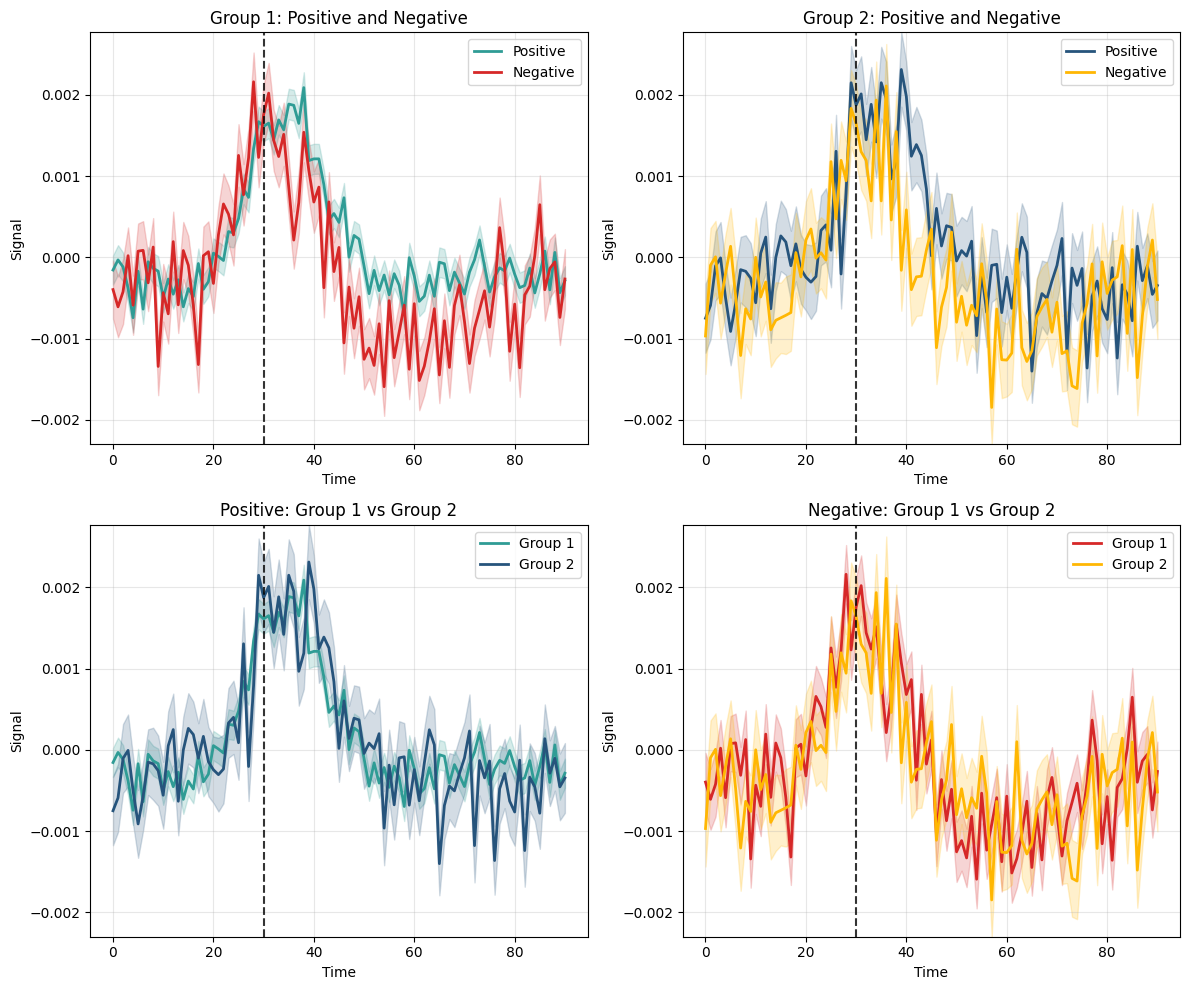

In [437]:
# Setting up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Calculate global y-limits
all_signals = [avg1_pos, avg1_neg, avg2_pos, avg2_neg]
all_sem = [sem1_pos, sem1_neg, sem2_pos, sem2_neg]
y_min = min((avg - sem).min() for avg, sem in zip(all_signals, all_sem))
y_max = max((avg + sem).max() for avg, sem in zip(all_signals, all_sem))

# Top Left: Group 1 (Positive and Negative)
axes[0, 0].plot(time, avg1_pos, color='#2f9c95', linewidth=2, label='Positive')
axes[0, 0].fill_between(time, avg1_pos - sem1_pos, avg1_pos + sem1_pos, color='#2f9c95', alpha=0.2)
axes[0, 0].plot(time, avg1_neg, color='#d62828', linewidth=2, label='Negative')
axes[0, 0].fill_between(time, avg1_neg - sem1_neg, avg1_neg + sem1_neg, color='#d62828', alpha=0.2)
axes[0, 0].set_title('Group 1: Positive and Negative')
axes[0, 0].axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
axes[0, 0].legend()
axes[0, 0].set_ylim(y_min, y_max)

# Top Right: Group 2 (Positive and Negative)
axes[0, 1].plot(time, avg2_pos, color='#26547c', linewidth=2, label='Positive')
axes[0, 1].fill_between(time, avg2_pos - sem2_pos, avg2_pos + sem2_pos, color='#26547c', alpha=0.2)
axes[0, 1].plot(time, avg2_neg, color='#ffb703', linewidth=2, label='Negative')
axes[0, 1].fill_between(time, avg2_neg - sem2_neg, avg2_neg + sem2_neg, color='#ffb703', alpha=0.2)
axes[0, 1].set_title('Group 2: Positive and Negative')
axes[0, 1].axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
axes[0, 1].legend()
axes[0, 1].set_ylim(y_min, y_max)

# Bottom Left: Positive (Group 1 vs. Group 2)
axes[1, 0].plot(time, avg1_pos, color='#2f9c95', linewidth=2, label='Group 1')
axes[1, 0].fill_between(time, avg1_pos - sem1_pos, avg1_pos + sem1_pos, color='#2f9c95', alpha=0.2)
axes[1, 0].plot(time, avg2_pos, color='#26547c', linewidth=2, label='Group 2')
axes[1, 0].fill_between(time, avg2_pos - sem2_pos, avg2_pos + sem2_pos, color='#26547c', alpha=0.2)
axes[1, 0].set_title('Positive: Group 1 vs Group 2')
axes[1, 0].axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
axes[1, 0].legend()
axes[1, 0].set_ylim(y_min, y_max)

# Bottom Right: Negative (Group 1 vs. Group 2)
axes[1, 1].plot(time, avg1_neg, color='#d62828', linewidth=2, label='Group 1')
axes[1, 1].fill_between(time, avg1_neg - sem1_neg, avg1_neg + sem1_neg, color='#d62828', alpha=0.2)
axes[1, 1].plot(time, avg2_neg, color='#ffb703', linewidth=2, label='Group 2')
axes[1, 1].fill_between(time, avg2_neg - sem2_neg, avg2_neg + sem2_neg, color='#ffb703', alpha=0.2)
axes[1, 1].set_title('Negative: Group 1 vs Group 2')
axes[1, 1].axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
axes[1, 1].legend()
axes[1, 1].set_ylim(y_min, y_max)

# Finalize layout
for ax in axes.flat:
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


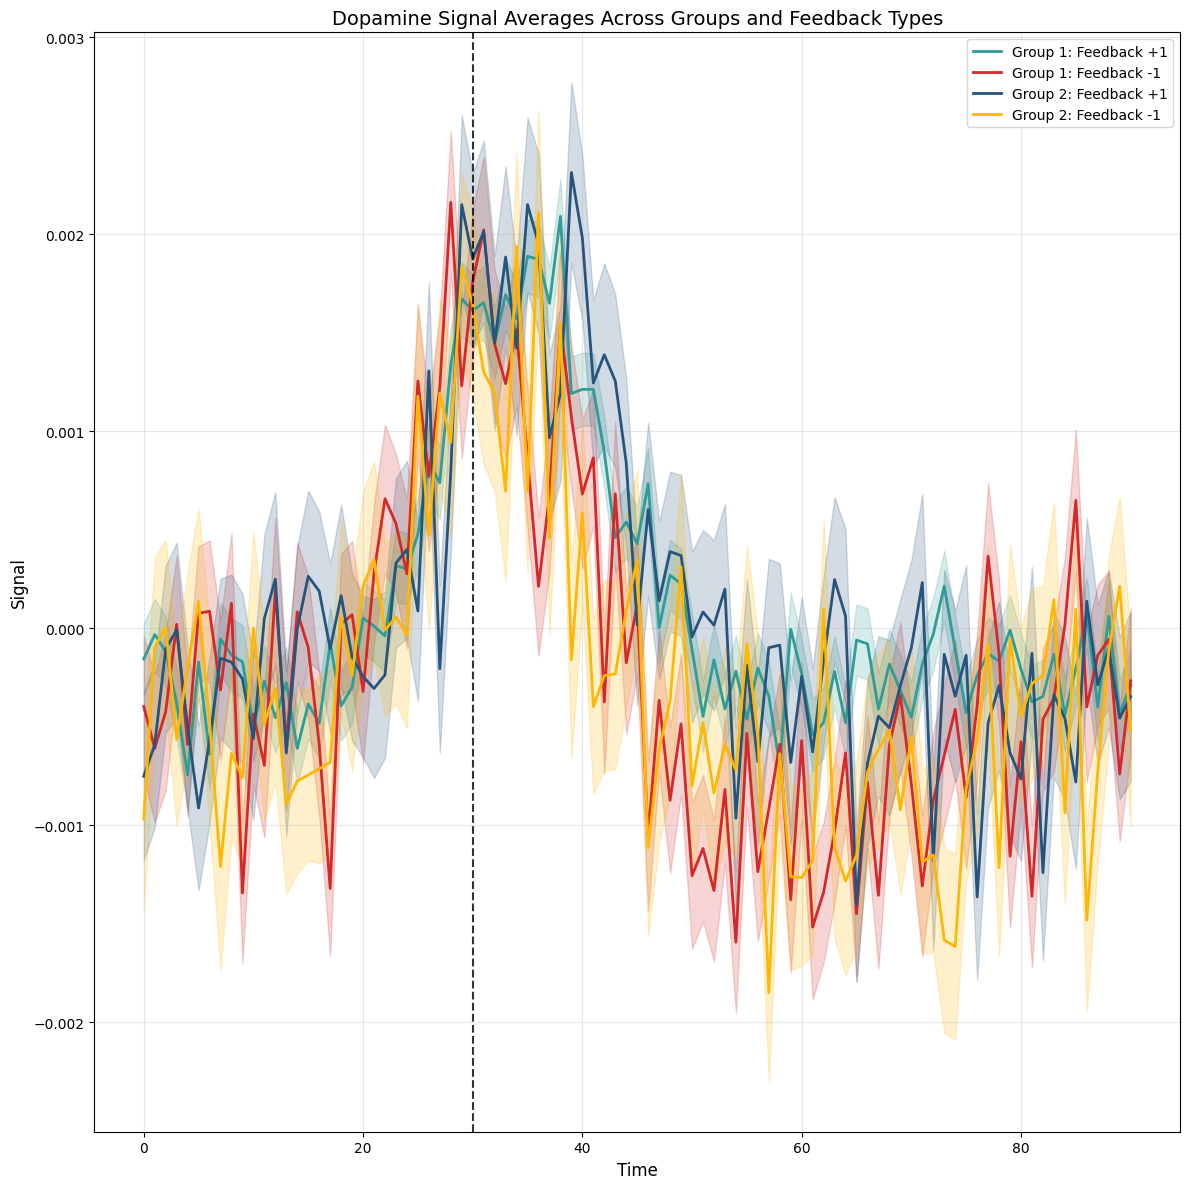

In [438]:
# Combined Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Group 1 Feedback +1
ax.plot(time, avg1_pos, color='#2f9c95', linewidth=2, label='Group 1: Feedback +1')
ax.fill_between(time, avg1_pos - sem1_pos, avg1_pos + sem1_pos, color='#2f9c95', alpha=0.2)

# Group 1 Feedback -1
ax.plot(time, avg1_neg, color='#d62828', linewidth=2, label='Group 1: Feedback -1')
ax.fill_between(time, avg1_neg - sem1_neg, avg1_neg + sem1_neg, color='#d62828', alpha=0.2)

# Group 2 Feedback +1
ax.plot(time, avg2_pos, color='#26547c', linewidth=2, label='Group 2: Feedback +1')
ax.fill_between(time, avg2_pos - sem2_pos, avg2_pos + sem2_pos, color='#26547c', alpha=0.2)

# Group 2 Feedback -1
ax.plot(time, avg2_neg, color='#ffb703', linewidth=2, label='Group 2: Feedback -1')
ax.fill_between(time, avg2_neg - sem2_neg, avg2_neg + sem2_neg, color='#ffb703', alpha=0.2)

# Customize Plot
ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8, linewidth=1.5)
ax.set_title('Dopamine Signal Averages Across Groups and Feedback Types', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Signal', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [439]:

# Statistical Analysis
# Combine signals for comparison
all_signals = [
    group1_feedback_pos.flatten(), 
    group1_feedback_neg.flatten(), 
    group2_feedback_pos.flatten(), 
    group2_feedback_neg.flatten()
]
labels = ['Group1_Pos', 'Group1_Neg', 'Group2_Pos', 'Group2_Neg']

# Normality Check
normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}

# Homogeneity of variances
homogeneity_result = levene(*all_signals)

# Choosing test based on results
if all(r.pvalue > 0.05 for r in normality_results.values()) and homogeneity_result.pvalue > 0.05:
    # Perform ANOVA
    anova_result = f_oneway(*all_signals)
    print("ANOVA Result:", anova_result)

    if anova_result.pvalue < 0.05:
        # Post Hoc Analysis
        flattened_signals = np.concatenate(all_signals)
        group_labels = np.concatenate([[label] * len(signal) for label, signal in zip(labels, all_signals)])
        posthoc_result = pairwise_tukeyhsd(flattened_signals, group_labels)
        print(posthoc_result)
else:
    # Perform Kruskal-Wallis
    kruskal_result = kruskal(*all_signals)
    print("Kruskal-Wallis Result:", kruskal_result)

    if kruskal_result.pvalue < 0.05:
        print("Significant differences, consider pairwise tests like Dunn's.")

Kruskal-Wallis Result: KruskalResult(statistic=70.03776843077503, pvalue=4.1895872815266265e-15)
Significant differences, consider pairwise tests like Dunn's.


/tmp/ipykernel_910944/4279350925.py:12: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 239967.
  normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}
/tmp/ipykernel_910944/4279350925.py:12: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 56329.
  normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}
/tmp/ipykernel_910944/4279350925.py:12: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40677.
  normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}
/tmp/ipykernel_910944/4279350925.py:12: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35672.
  normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}


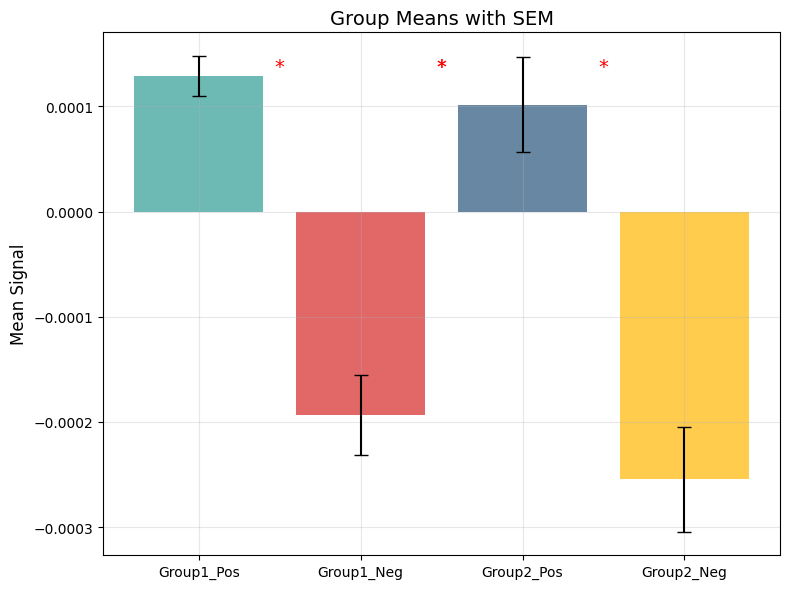

Significant Differences Detected:
Group1_Neg vs Group1_Pos: p=0.000e+00
Group1_Neg vs Group2_Pos: p=0.000e+00
Group1_Pos vs Group2_Neg: p=0.000e+00
Group2_Neg vs Group2_Pos: p=0.000e+00


In [440]:
# Organize signals for statistical comparison
flattened_signals = np.concatenate(all_signals)
group_labels = np.concatenate([[label] * len(signal) for label, signal in zip(labels, all_signals)])

# ANOVA with Tukey Post Hoc
anova_result = f_oneway(*all_signals)
posthoc_result = pairwise_tukeyhsd(flattened_signals, group_labels)

# Create a summary dataframe
tukey_df = pd.DataFrame(data=posthoc_result.summary().data[1:], columns=posthoc_result.summary().data[0])

# Plot Statistical Results
group_means = [np.mean(signal) for signal in all_signals]
group_sems = [np.std(signal) / np.sqrt(len(signal)) for signal in all_signals]

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot with error bars
x = np.arange(len(labels))
ax.bar(x, group_means, yerr=group_sems, color=['#2f9c95', '#d62828', '#26547c', '#ffb703'], alpha=0.7, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Group Means with SEM', fontsize=14)
ax.set_ylabel('Mean Signal', fontsize=12)
ax.grid(alpha=0.3)

# Add significance annotations
significance_markers = []
for i, row in tukey_df.iterrows():
    if row['reject']:
        significance_markers.append(f"{row['group1']} vs {row['group2']}: p={row['p-adj']:.3e}")
        ax.text(
            (x[labels.index(row['group1'])] + x[labels.index(row['group2'])]) / 2,
            max(group_means),
            '*', ha='center', va='bottom', fontsize=14, color='red'
        )

plt.tight_layout()
plt.show()

# Print significant results
if significance_markers:
    print("Significant Differences Detected:")
    for marker in significance_markers:
        print(marker)
else:
    print("No significant differences found.")

Kruskal-Wallis Result: KruskalResult(statistic=7.060016096413165, pvalue=0.0700092585383702)


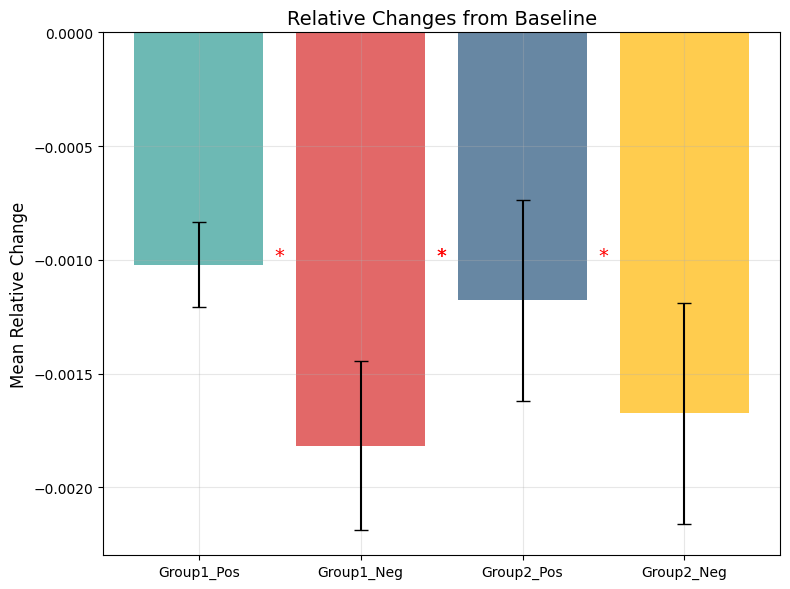

Significant Differences Detected:
Group1_Neg vs Group1_Pos: p=0.000e+00
Group1_Neg vs Group2_Pos: p=0.000e+00
Group1_Pos vs Group2_Neg: p=0.000e+00
Group2_Neg vs Group2_Pos: p=0.000e+00


In [441]:
# Define baseline and post-event window indices
baseline_idx = 30
post_event_start = 31
post_event_end = 60  # inclusive

# Extract baseline and post-event signals
def extract_relative_change(signal):
    baseline = signal[baseline_idx, :]
    post_event = signal[post_event_start:post_event_end + 1, :]
    # Calculate relative change from baseline
    relative_change = post_event.mean(axis=0) - baseline
    return relative_change

group1_feedback_pos_change = extract_relative_change(group1_feedback_pos)
group1_feedback_neg_change = extract_relative_change(group1_feedback_neg)
group2_feedback_pos_change = extract_relative_change(group2_feedback_pos)
group2_feedback_neg_change = extract_relative_change(group2_feedback_neg)

# Combine signals for statistical analysis
all_signals = [
    group1_feedback_pos_change,
    group1_feedback_neg_change,
    group2_feedback_pos_change,
    group2_feedback_neg_change,
]
labels = ['Group1_Pos', 'Group1_Neg', 'Group2_Pos', 'Group2_Neg']

# Statistical Analysis
# Normality Check
normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}

# Homogeneity of variances
homogeneity_result = levene(*all_signals)

# Perform statistical test based on assumptions
if all(r.pvalue > 0.05 for r in normality_results.values()) and homogeneity_result.pvalue > 0.05:
    # Perform ANOVA
    anova_result = f_oneway(*all_signals)
    print("ANOVA Result:", anova_result)

    if anova_result.pvalue < 0.05:
        # Post Hoc Analysis
        flattened_signals = np.concatenate(all_signals)
        group_labels = np.concatenate([[label] * len(signal) for label, signal in zip(labels, all_signals)])
        posthoc_result = pairwise_tukeyhsd(flattened_signals, group_labels)
        print(posthoc_result)
else:
    # Perform Kruskal-Wallis
    kruskal_result = kruskal(*all_signals)
    print("Kruskal-Wallis Result:", kruskal_result)

    if kruskal_result.pvalue < 0.05:
        print("Significant differences, consider pairwise tests like Dunn's.")

# Visualization: Group Means with SEM
group_means = [np.mean(signal) for signal in all_signals]
group_sems = [np.std(signal) / np.sqrt(len(signal)) for signal in all_signals]

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot with error bars
x = np.arange(len(labels))
ax.bar(x, group_means, yerr=group_sems, color=['#2f9c95', '#d62828', '#26547c', '#ffb703'], alpha=0.7, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Relative Changes from Baseline', fontsize=14)
ax.set_ylabel('Mean Relative Change', fontsize=12)
ax.grid(alpha=0.3)

# Add significance annotations if Tukey is performed
if 'posthoc_result' in locals():
    significance_markers = []
    tukey_df = pd.DataFrame(data=posthoc_result.summary().data[1:], columns=posthoc_result.summary().data[0])
    for i, row in tukey_df.iterrows():
        if row['reject']:
            significance_markers.append(f"{row['group1']} vs {row['group2']}: p={row['p-adj']:.3e}")
            ax.text(
                (x[labels.index(row['group1'])] + x[labels.index(row['group2'])]) / 2,
                max(group_means),
                '*', ha='center', va='bottom', fontsize=14, color='red'
            )
else:
    significance_markers = []

plt.tight_layout()
plt.show()

# Print significant results
if significance_markers:
    print("Significant Differences Detected:")
    for marker in significance_markers:
        print(marker)
else:
    print("No significant differences found.")


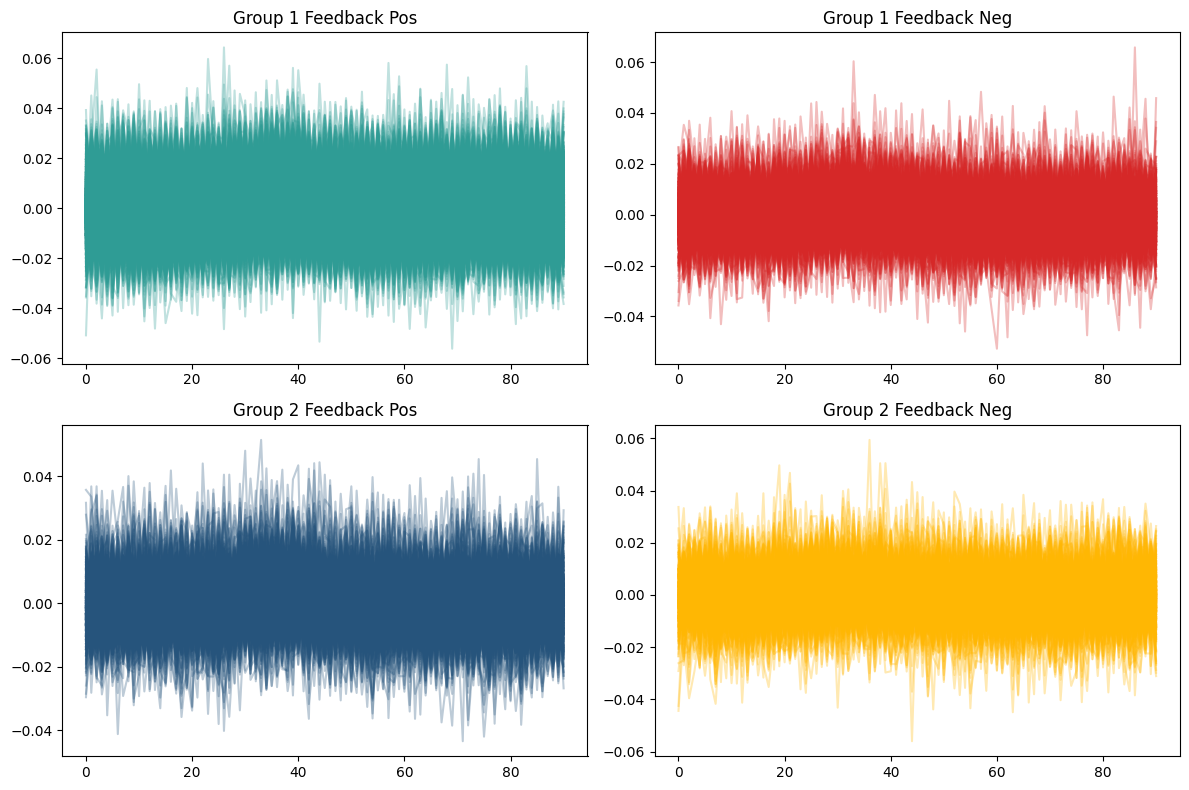

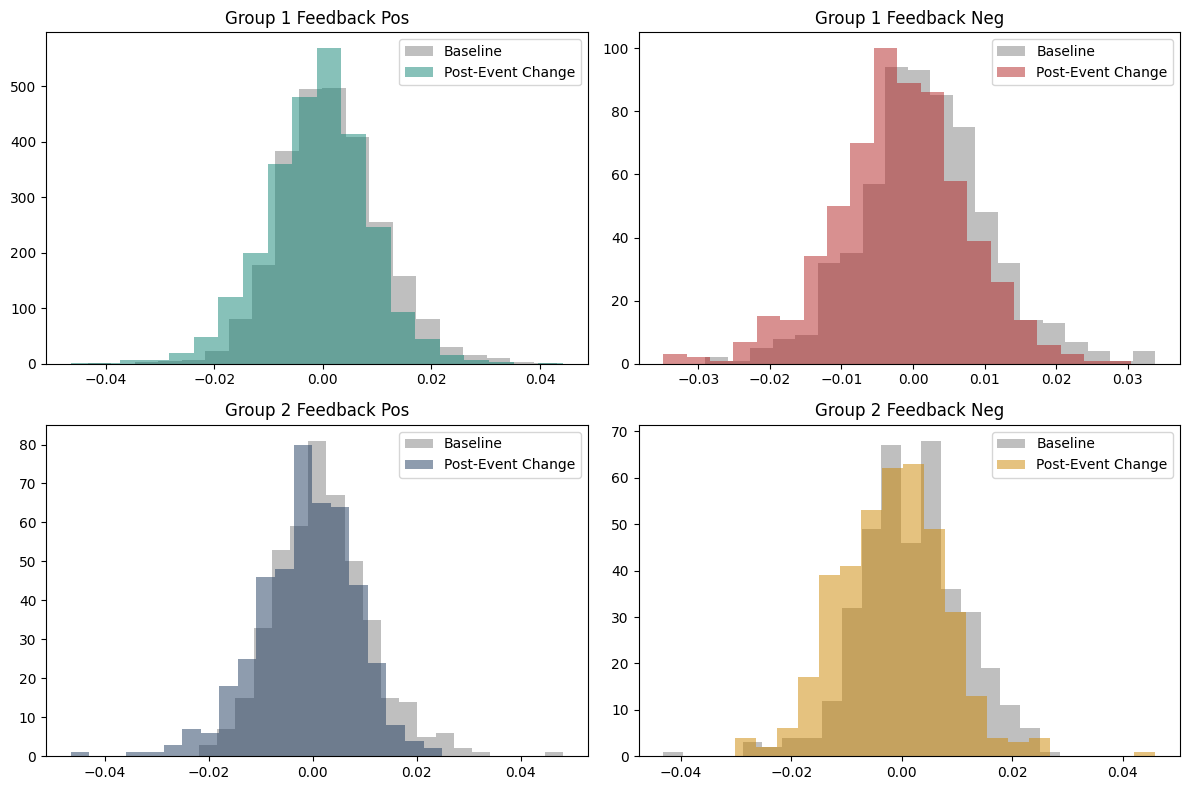

Kruskal-Wallis Result: KruskalResult(statistic=7.060016096413165, pvalue=0.0700092585383702)


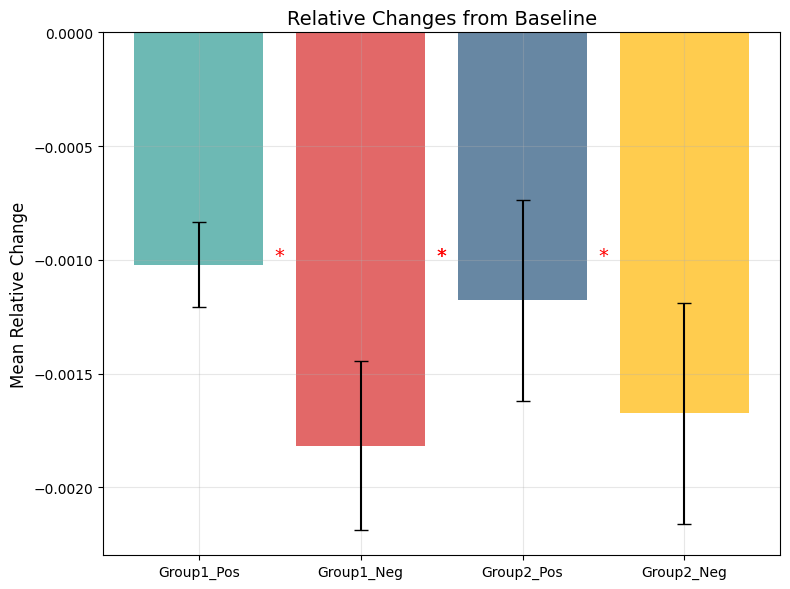

Significant Differences Detected:
Group1_Neg vs Group1_Pos: p=0.000e+00
Group1_Neg vs Group2_Pos: p=0.000e+00
Group1_Pos vs Group2_Neg: p=0.000e+00
Group2_Neg vs Group2_Pos: p=0.000e+00


In [442]:
# Define indices
baseline_idx = 30
post_event_start = 31
post_event_end = 60  # inclusive

# Step 1: Visualize Original Signals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].plot(group1_feedback_pos, alpha=0.3, color='#2f9c95')
axes[0, 0].set_title("Group 1 Feedback Pos")
axes[0, 1].plot(group1_feedback_neg, alpha=0.3, color='#d62828')
axes[0, 1].set_title("Group 1 Feedback Neg")
axes[1, 0].plot(group2_feedback_pos, alpha=0.3, color='#26547c')
axes[1, 0].set_title("Group 2 Feedback Pos")
axes[1, 1].plot(group2_feedback_neg, alpha=0.3, color='#ffb703')
axes[1, 1].set_title("Group 2 Feedback Neg")
plt.tight_layout()
plt.show()

# Step 2: Extract baseline and post-event relative changes
def extract_relative_change(signal):
    # Use exact baseline value at x=30 for each trial
    baseline = signal[baseline_idx, :]  
    # Calculate the mean value of the post-event window
    post_event = signal[post_event_start:post_event_end + 1, :].mean(axis=0)
    # Subtract baseline from post-event mean to calculate relative change
    relative_change = post_event - baseline
    return baseline, relative_change

# Compute baseline and relative changes
baseline1_pos, group1_feedback_pos_change = extract_relative_change(group1_feedback_pos)
baseline1_neg, group1_feedback_neg_change = extract_relative_change(group1_feedback_neg)
baseline2_pos, group2_feedback_pos_change = extract_relative_change(group2_feedback_pos)
baseline2_neg, group2_feedback_neg_change = extract_relative_change(group2_feedback_neg)

# Step 3: Visualize Baseline and Post-Event Changes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].hist(baseline1_pos, bins=20, color='gray', alpha=0.5, label="Baseline")
axes[0, 0].hist(group1_feedback_pos_change, bins=20, color='#118475', alpha=0.5, label="Post-Event Change")
axes[0, 0].set_title("Group 1 Feedback Pos")
axes[0, 0].legend()

axes[0, 1].hist(baseline1_neg, bins=20, color='gray', alpha=0.5, label="Baseline")
axes[0, 1].hist(group1_feedback_neg_change, bins=20, color='#b22222', alpha=0.5, label="Post-Event Change")
axes[0, 1].set_title("Group 1 Feedback Neg")
axes[0, 1].legend()

axes[1, 0].hist(baseline2_pos, bins=20, color='gray', alpha=0.5, label="Baseline")
axes[1, 0].hist(group2_feedback_pos_change, bins=20, color='#1e3a5f', alpha=0.5, label="Post-Event Change")
axes[1, 0].set_title("Group 2 Feedback Pos")
axes[1, 0].legend()

axes[1, 1].hist(baseline2_neg, bins=20, color='gray', alpha=0.5, label="Baseline")
axes[1, 1].hist(group2_feedback_neg_change, bins=20, color='#cc8600', alpha=0.5, label="Post-Event Change")
axes[1, 1].set_title("Group 2 Feedback Neg")
axes[1, 1].legend()
plt.tight_layout()
plt.show()

# Step 4: Statistical Analysis
all_signals = [
    group1_feedback_pos_change,
    group1_feedback_neg_change,
    group2_feedback_pos_change,
    group2_feedback_neg_change,
]
labels = ['Group1_Pos', 'Group1_Neg', 'Group2_Pos', 'Group2_Neg']

# Normality Check
normality_results = {label: shapiro(signal) for label, signal in zip(labels, all_signals)}

# Homogeneity of variances
homogeneity_result = levene(*all_signals)

# Perform statistical test based on assumptions
if all(r.pvalue > 0.05 for r in normality_results.values()) and homogeneity_result.pvalue > 0.05:
    # Perform ANOVA
    anova_result = f_oneway(*all_signals)
    print("ANOVA Result:", anova_result)

    if anova_result.pvalue < 0.05:
        # Post Hoc Analysis
        flattened_signals = np.concatenate(all_signals)
        group_labels = np.concatenate([[label] * len(signal) for label, signal in zip(labels, all_signals)])
        posthoc_result = pairwise_tukeyhsd(flattened_signals, group_labels)
        print(posthoc_result)
else:
    # Perform Kruskal-Wallis
    kruskal_result = kruskal(*all_signals)
    print("Kruskal-Wallis Result:", kruskal_result)

# Step 5: Visualize Results
group_means = [np.mean(signal) for signal in all_signals]
group_sems = [np.std(signal) / np.sqrt(len(signal)) for signal in all_signals]

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot with error bars
x = np.arange(len(labels))
ax.bar(x, group_means, yerr=group_sems, color=['#2f9c95', '#d62828', '#26547c', '#ffb703'], alpha=0.7, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Relative Changes from Baseline', fontsize=14)
ax.set_ylabel('Mean Relative Change', fontsize=12)
ax.grid(alpha=0.3)

# Add significance annotations if Tukey is performed
if 'posthoc_result' in locals():
    significance_markers = []
    tukey_df = pd.DataFrame(data=posthoc_result.summary().data[1:], columns=posthoc_result.summary().data[0])
    for i, row in tukey_df.iterrows():
        if row['reject']:
            significance_markers.append(f"{row['group1']} vs {row['group2']}: p={row['p-adj']:.3e}")
            ax.text(
                (x[labels.index(row['group1'])] + x[labels.index(row['group2'])]) / 2,
                max(group_means),
                '*', ha='center', va='bottom', fontsize=14, color='red'
            )
else:
    significance_markers = []

plt.tight_layout()
plt.show()

# Print significant results
if significance_markers:
    print("Significant Differences Detected:")
    for marker in significance_markers:
        print(marker)
else:
    print("No significant differences found.")


In [443]:
df_trials_combined_DA.allContrasts.unique() 


array([1.    , 0.125 , 0.0625, 0.    , 0.25  ])

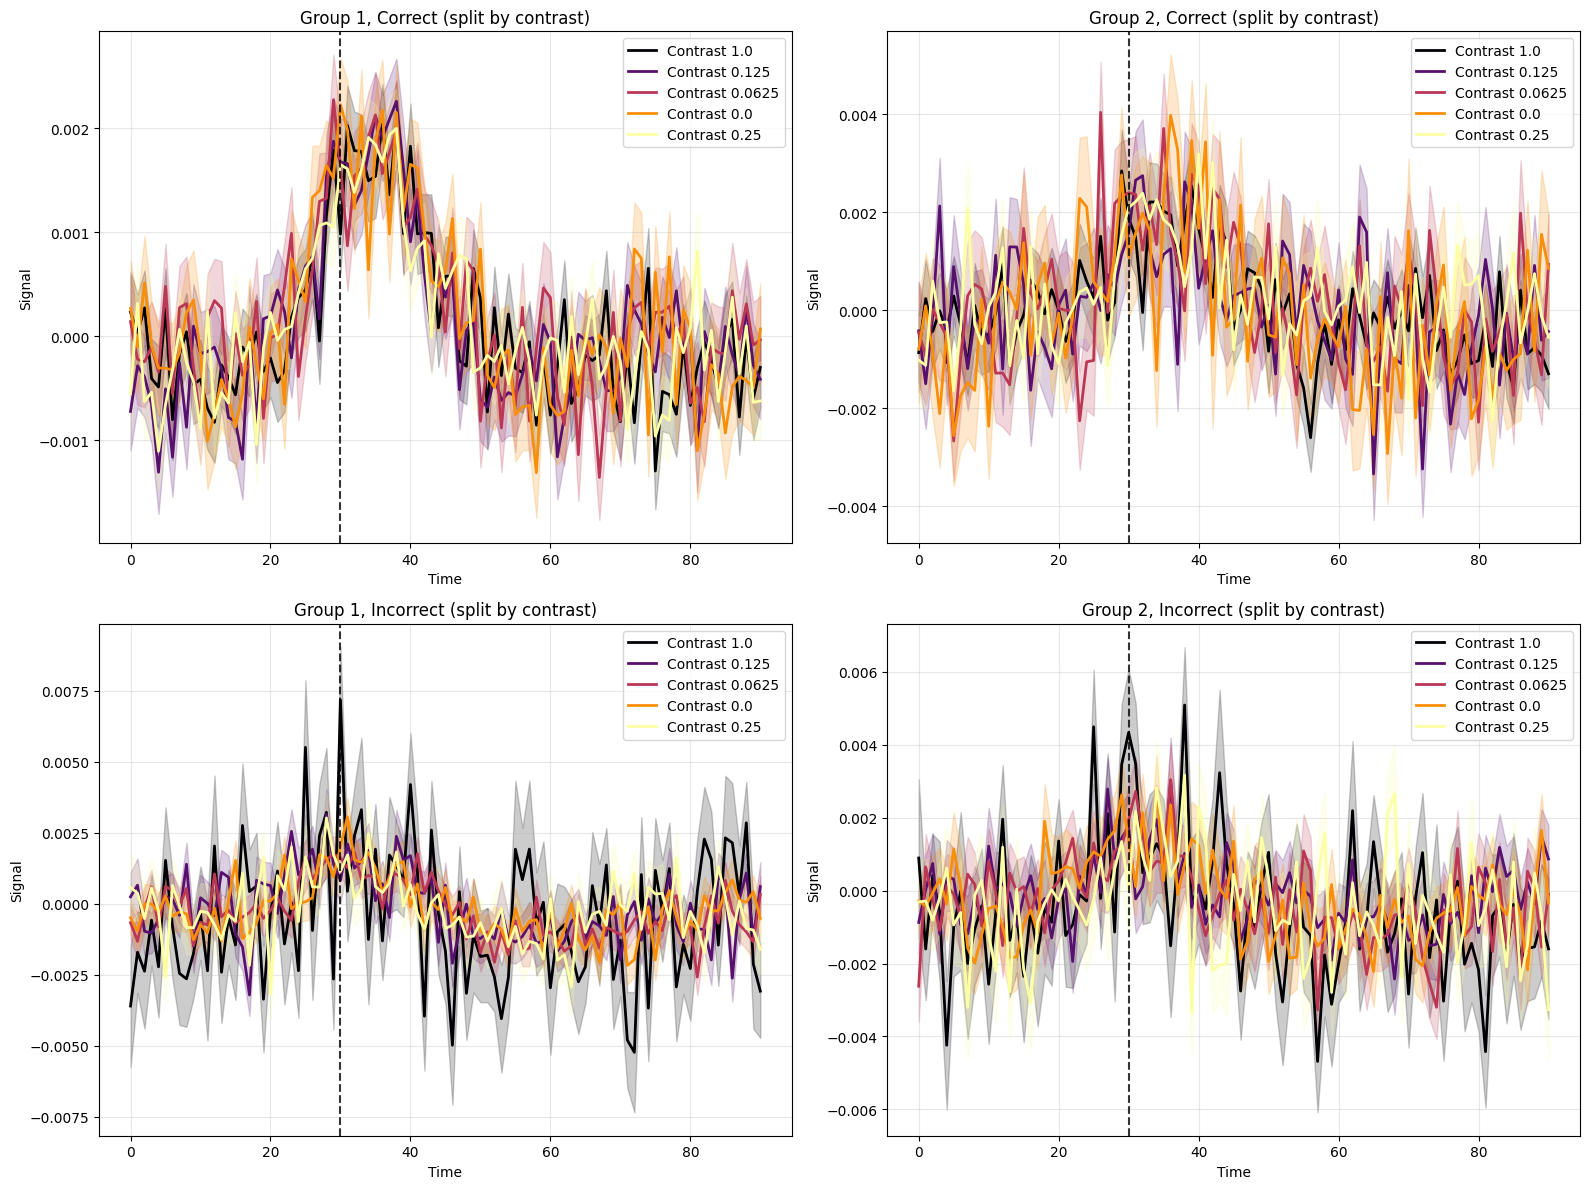

In [444]:
# Extract all unique contrasts
all_contrasts = df_trials_combined_DA['allContrasts'].unique()

# Function to extract signals for each contrast and correctness
def extract_signals(group_indices, feedback_type, contrast, correctness):
    contrast_indices = df_trials_combined_DA['allContrasts'] == contrast
    correct_indices = feedback_type == correctness
    indices = group_indices & contrast_indices & correct_indices
    return psth_combined_DA[:, indices]

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Colors for each contrast
colors = plt.cm.inferno(np.linspace(0, 1, len(all_contrasts)))

# Plot settings
titles = [
    "Group 1, Correct (split by contrast)",
    "Group 2, Correct (split by contrast)",
    "Group 1, Incorrect (split by contrast)",
    "Group 2, Incorrect (split by contrast)"
]

# Iterate over axes to fill with plots
for ax, group_indices, correctness, title in zip(
    axes.flat,
    [group1_indices, group2_indices, group1_indices, group2_indices],
    [1, 1, -1, -1],
    titles
):
    for contrast, color in zip(all_contrasts, colors):
        signal = extract_signals(group_indices, feedback_type, contrast, correctness)
        avg, sem = compute_avg_sem(signal)
        ax.plot(time, avg, color=color, linewidth=2, label=f'Contrast {contrast}')
        ax.fill_between(time, avg - sem, avg + sem, color=color, alpha=0.2)

    ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


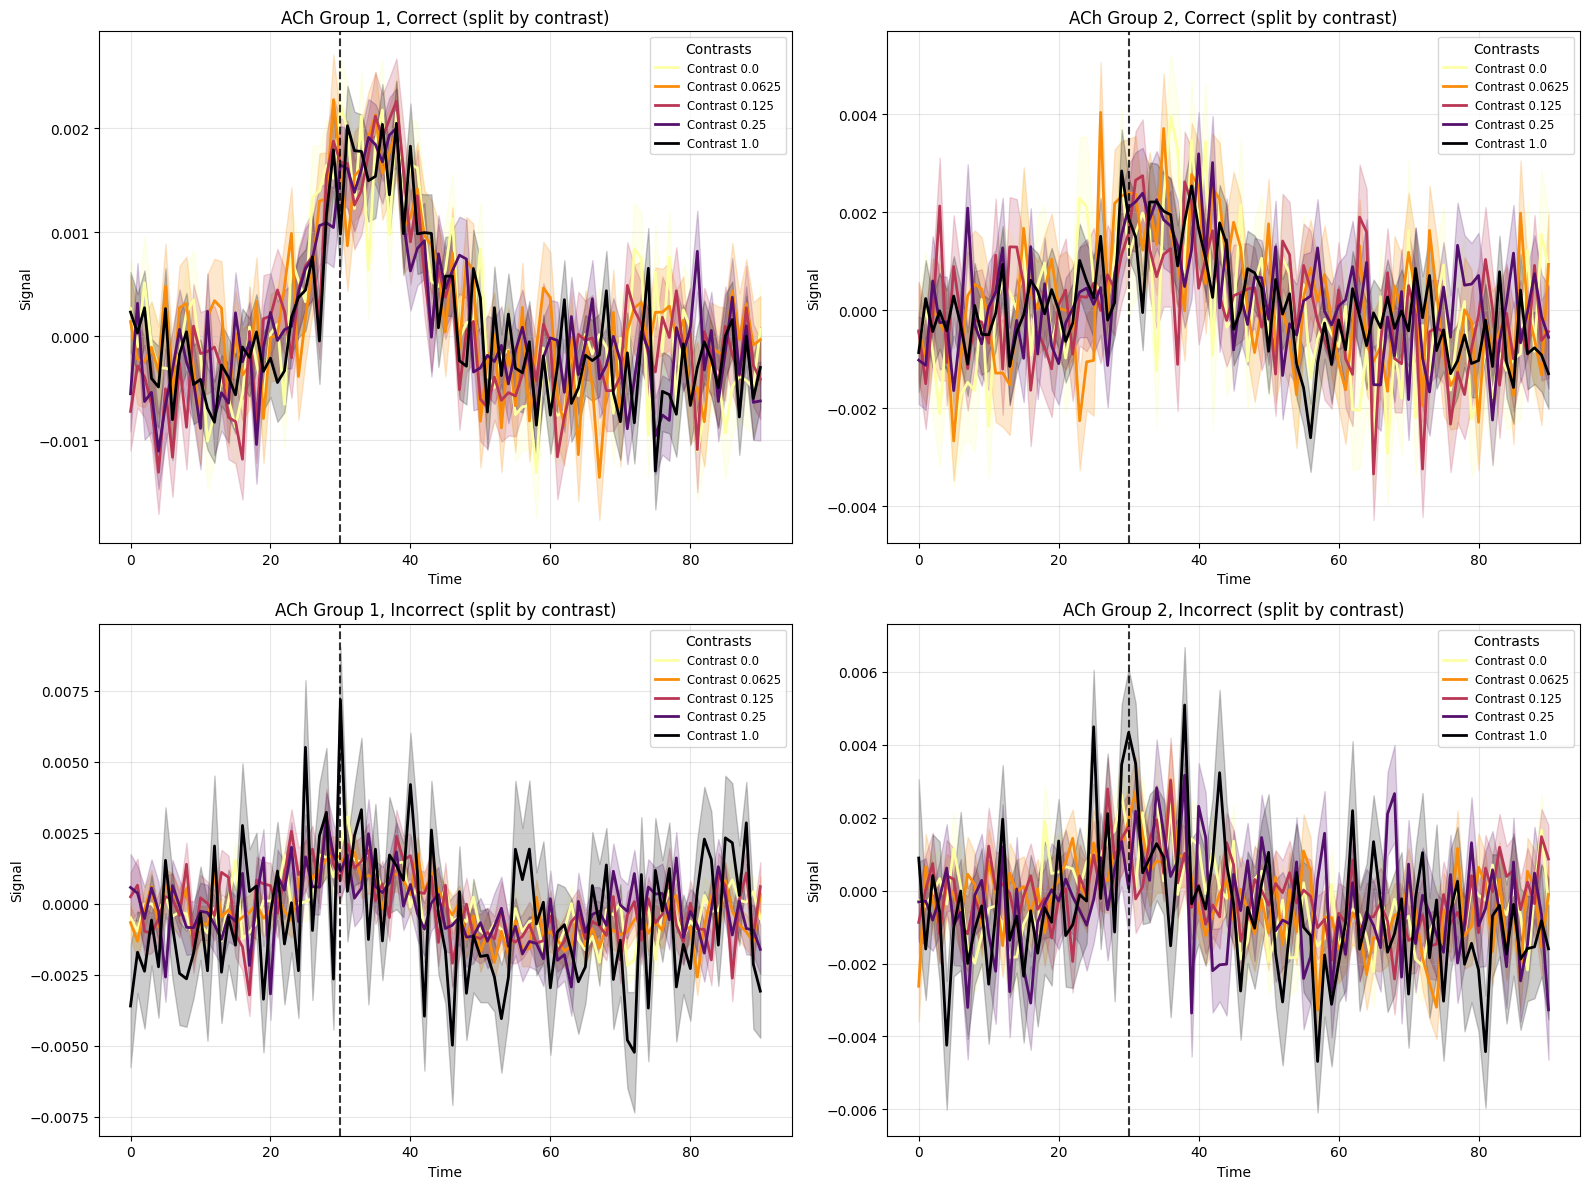

In [445]:
# Extract all unique contrasts and sort them for consistent color mapping
all_contrasts = np.sort(df_trials_combined_DA['allContrasts'].unique())

# Function to extract signals for each contrast and correctness
def extract_signals(group_indices, feedback_type, contrast, correctness):
    contrast_indices = df_trials_combined_DA['allContrasts'] == contrast
    correct_indices = feedback_type == correctness
    indices = group_indices & contrast_indices & correct_indices
    return psth_combined_DA[:, indices]

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Colors for each contrast, darker shades for higher contrasts
colors = plt.cm.inferno_r(np.linspace(0, 1, len(all_contrasts)))

# Titles for subplots
titles = [
    "Group 1, Correct (split by contrast)",
    "Group 2, Correct (split by contrast)",
    "Group 1, Incorrect (split by contrast)",
    "Group 2, Incorrect (split by contrast)"
]

# Iterate over axes to fill with plots
for ax, group_indices, correctness, title in zip(
    axes.flat,
    [group1_indices, group2_indices, group1_indices, group2_indices],
    [1, 1, -1, -1],
    titles
):
    for contrast, color in zip(all_contrasts, colors):
        signal = extract_signals(group_indices, feedback_type, contrast, correctness)
        if signal.size > 0:  # Avoid plotting empty signals
            avg, sem = compute_avg_sem(signal)
            ax.plot(time, avg, color=color, linewidth=2, label=f'Contrast {contrast}')
            ax.fill_between(time, avg - sem, avg + sem, color=color, alpha=0.2)

    # Add a vertical line for the event time (baseline)
    ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
    ax.set_title(f'{NM}'+' '+title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)
    ax.legend(fontsize='small', title="Contrasts", loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


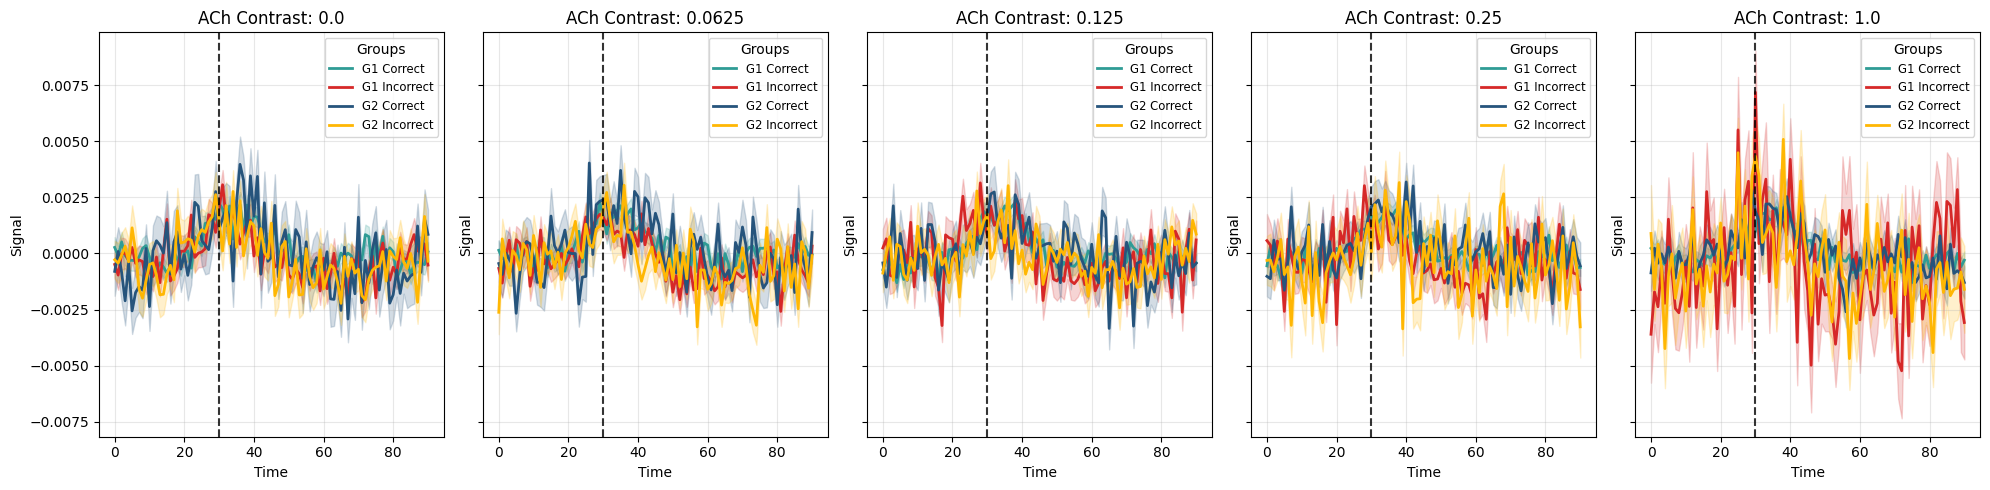

In [446]:
# Extract all unique contrasts and sort them for consistent color mapping
all_contrasts = np.sort(df_trials_combined_DA['allContrasts'].unique()) 
# all_contrasts = [0.    , 0.0625, 0.125 , 0.25    , 1.    ] 

# Function to extract signals for each group, feedback, and correctness
def extract_signals(group_indices, feedback_type, contrast, correctness):
    contrast_indices = df_trials_combined_DA['allContrasts'] == contrast
    correct_indices = feedback_type == correctness
    indices = group_indices & contrast_indices & correct_indices
    return psth_combined_DA[:, indices]

# Set up the figure
fig, axes = plt.subplots(1, len(all_contrasts), figsize=(20, 5), sharey=True)
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Colors for each group and correctness combination
colors = {
    "G1 Correct": "#2f9c95",
    "G1 Incorrect": "#d62828",
    "G2 Correct": "#26547c",
    "G2 Incorrect": "#ffb703"
}

# Iterate over contrasts and axes
for ax, contrast in zip(axes, all_contrasts):
    for label, (group_indices, correctness) in {
        "G1 Correct": (group1_indices, 1),
        "G1 Incorrect": (group1_indices, -1),
        "G2 Correct": (group2_indices, 1),
        "G2 Incorrect": (group2_indices, -1)
    }.items():
        signal = extract_signals(group_indices, feedback_type, contrast, correctness)
        if signal.size > 0:  # Avoid plotting empty signals
            avg, sem = compute_avg_sem(signal)
            ax.plot(time, avg, color=colors[label], linewidth=2, label=label)
            ax.fill_between(time, avg - sem, avg + sem, color=colors[label], alpha=0.2)
    
    # Add a vertical line for the event time (baseline)
    ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
    ax.set_title(f"{NM} Contrast: {contrast}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)
    ax.legend(fontsize='small', title="Groups", loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


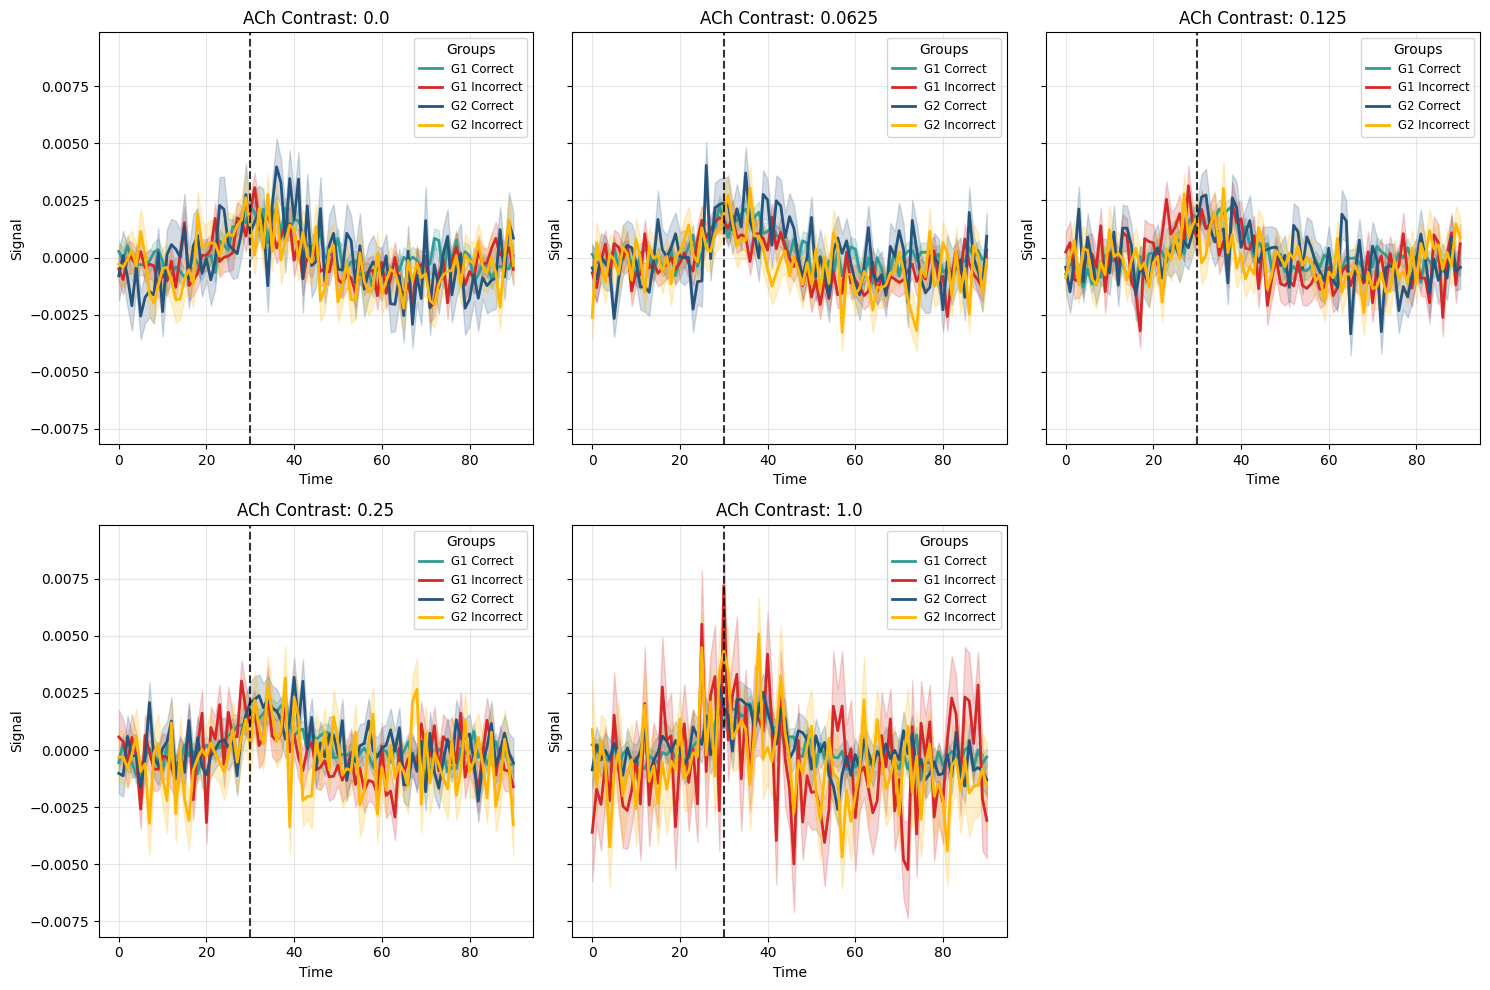

In [447]:
# Extract all unique contrasts and sort them for consistent color mapping
all_contrasts = np.sort(df_trials_combined_DA['allContrasts'].unique())

# Function to extract signals for each group, feedback, and correctness
def extract_signals(group_indices, feedback_type, contrast, correctness):
    contrast_indices = df_trials_combined_DA['allContrasts'] == contrast
    correct_indices = feedback_type == correctness
    indices = group_indices & contrast_indices & correct_indices
    return psth_combined_DA[:, indices]

# Set up the figure for 3 columns and 2 rows
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Flatten axes for easier iteration
axes = axes.flatten()

# Colors for each group and correctness combination
colors = {
    "G1 Correct": "#2f9c95",
    "G1 Incorrect": "#d62828",
    "G2 Correct": "#26547c",
    "G2 Incorrect": "#ffb703"
}

# Iterate over contrasts and axes
for ax, contrast in zip(axes, all_contrasts):
    for label, (group_indices, correctness) in {
        "G1 Correct": (group1_indices, 1),
        "G1 Incorrect": (group1_indices, -1),
        "G2 Correct": (group2_indices, 1),
        "G2 Incorrect": (group2_indices, -1)
    }.items():
        signal = extract_signals(group_indices, feedback_type, contrast, correctness)
        if signal.size > 0:  # Avoid plotting empty signals
            avg, sem = compute_avg_sem(signal)
            ax.plot(time, avg, color=colors[label], linewidth=2, label=label)
            ax.fill_between(time, avg - sem, avg + sem, color=colors[label], alpha=0.2)
    
    # Add a vertical line for the event time (baseline)
    ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
    ax.set_title(f"{NM} Contrast: {contrast}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)
    ax.legend(fontsize='small', title="Groups", loc='upper right')

# Turn off any unused subplots
for ax in axes[len(all_contrasts):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


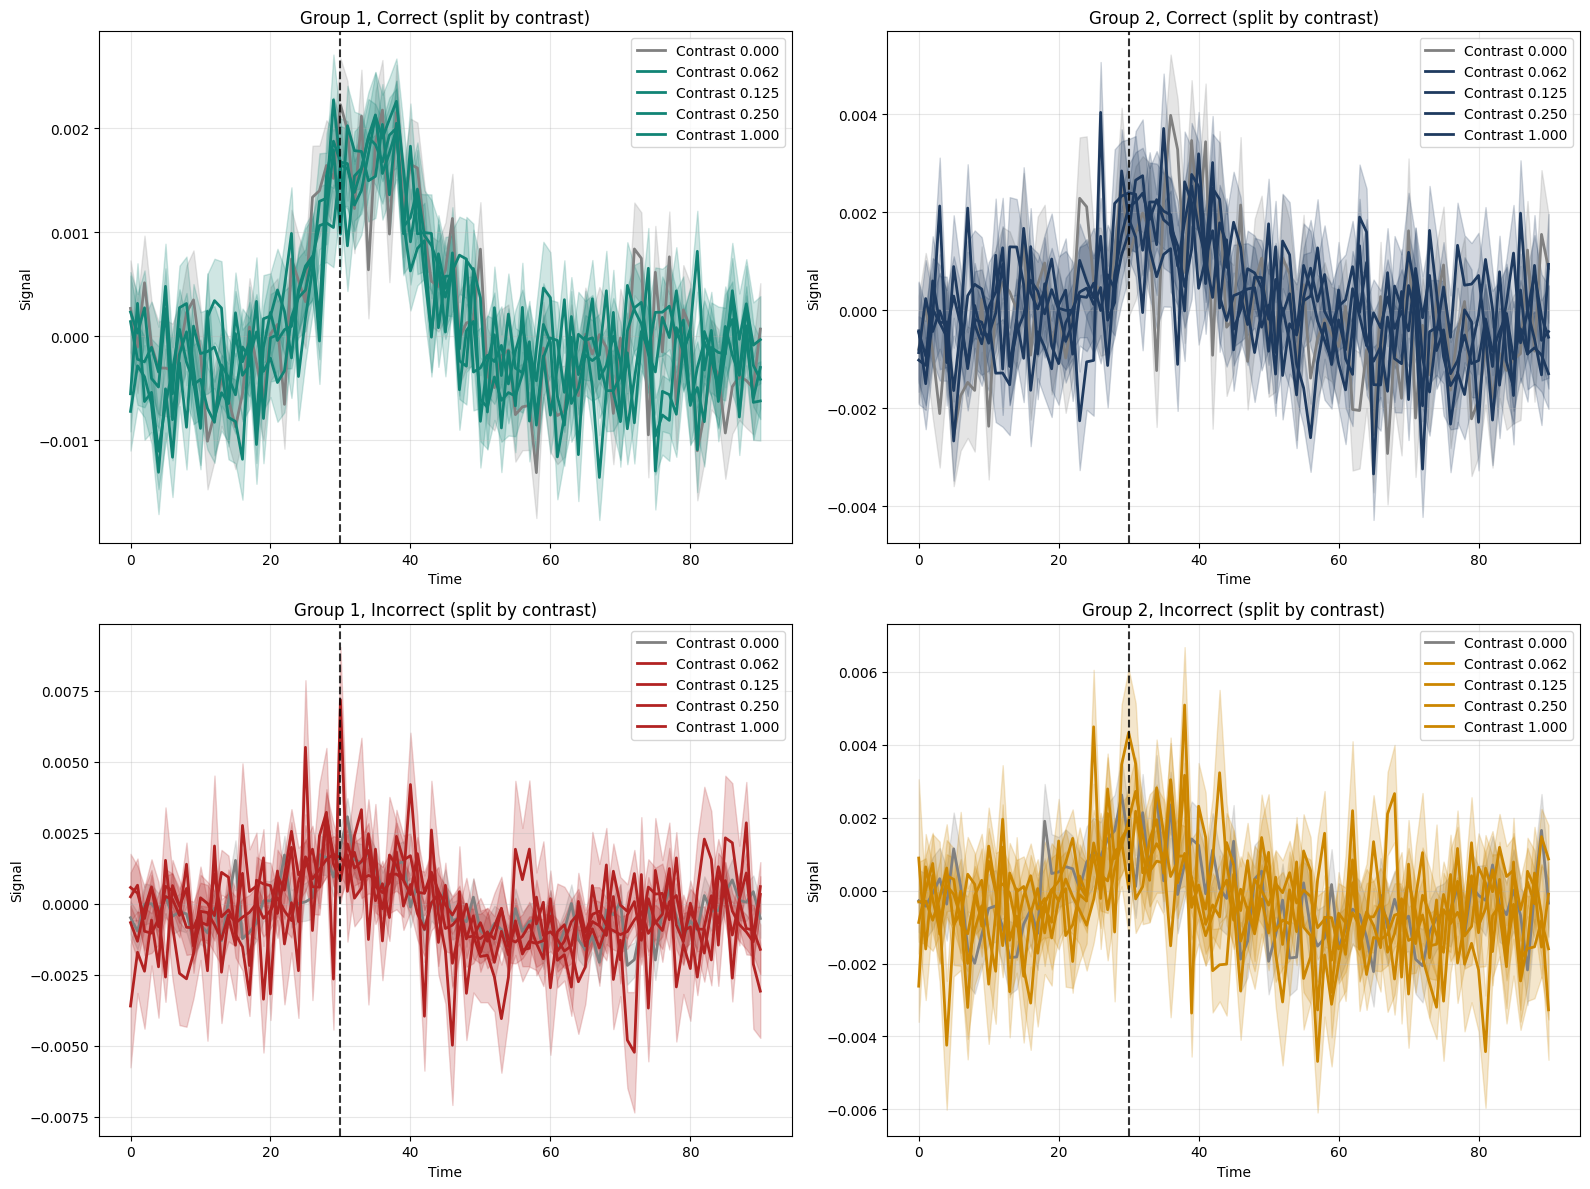

In [448]:
import matplotlib.colors as mcolors

# Define base colors
color_map = {
    "G1_correct": "#118475",
    "G1_incorrect": "#b22222",
    "G2_correct": "#1e3a5f",
    "G2_incorrect": "#cc8600",
    "neutral": "#808080"  # Gray for contrast ~ 0
}

# Normalize contrast values for intensity scaling
contrast_norm = np.abs(all_contrasts) / np.max(np.abs(all_contrasts))  # Scale contrasts between 0 and 1

# Helper function to blend colors based on contrast intensity
def blend_color(base_color, intensity):
    if intensity == 0:
        return color_map["neutral"]
    return mcolors.to_hex(mcolors.to_rgba(base_color, alpha=0.9 * intensity))

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Plot settings
titles = [
    "Group 1, Correct (split by contrast)",
    "Group 2, Correct (split by contrast)",
    "Group 1, Incorrect (split by contrast)",
    "Group 2, Incorrect (split by contrast)"
]

# Iterate over axes to fill with plots
for ax, group_indices, correctness, base_color_key, title in zip(
    axes.flat,
    [group1_indices, group2_indices, group1_indices, group2_indices],
    [1, 1, -1, -1],
    ["G1_correct", "G2_correct", "G1_incorrect", "G2_incorrect"],
    titles
):
    base_color = color_map[base_color_key]
    for contrast, intensity in zip(all_contrasts, contrast_norm):
        color = blend_color(base_color, intensity)
        signal = extract_signals(group_indices, feedback_type, contrast, correctness)
        avg, sem = compute_avg_sem(signal)
        ax.plot(time, avg, color=color, linewidth=2, label=f'Contrast {contrast:.3f}')
        ax.fill_between(time, avg - sem, avg + sem, color=color, alpha=0.2)

    ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


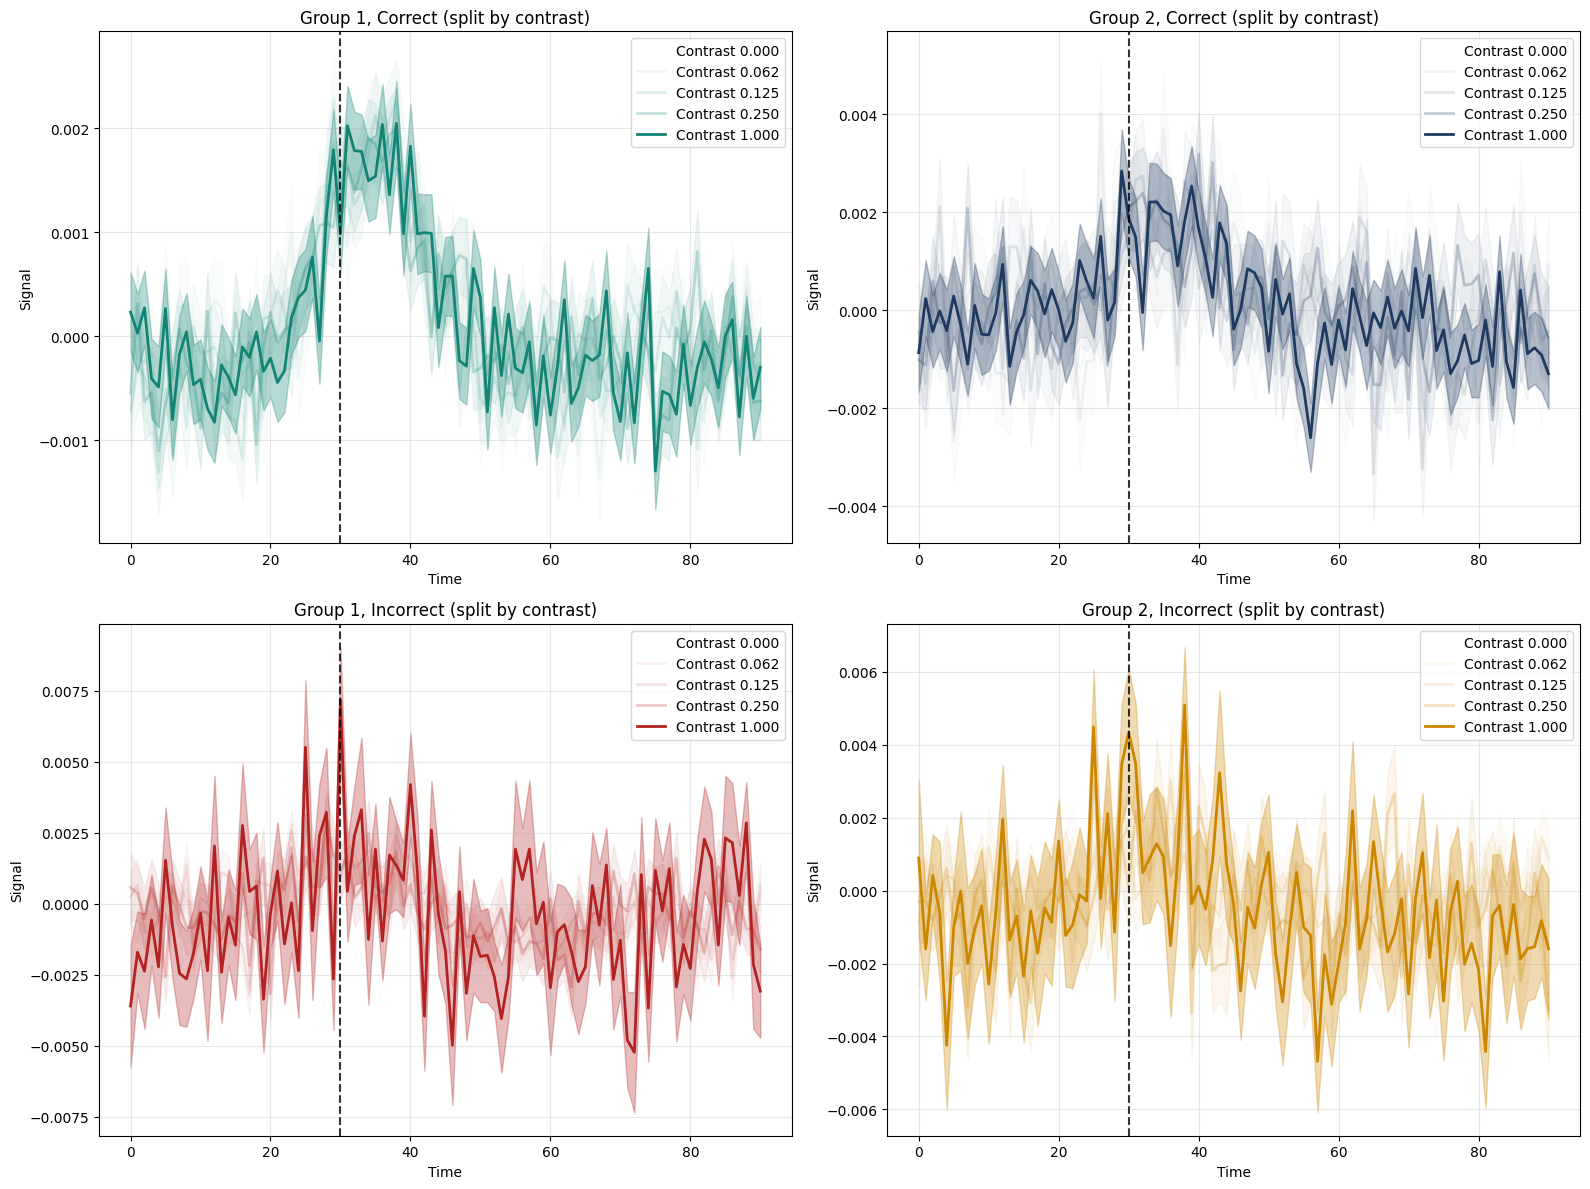

In [449]:
# Normalize contrast values for alpha scaling (map between 0 and 1)
contrast_alpha = np.abs(all_contrasts) / np.max(np.abs(all_contrasts))  # Absolute values for positive scaling

# Helper function to get color with adjusted alpha
def color_with_alpha(base_color, alpha):
    """
    Returns a color with the specified alpha applied.
    """
    return mcolors.to_rgba(base_color, alpha)

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

# Plot settings
titles = [
    "Group 1, Correct (split by contrast)",
    "Group 2, Correct (split by contrast)",
    "Group 1, Incorrect (split by contrast)",
    "Group 2, Incorrect (split by contrast)"
]

# Iterate over axes to fill with plots
for ax, group_indices, correctness, base_color_key, title in zip(
    axes.flat,
    [group1_indices, group2_indices, group1_indices, group2_indices],
    [1, 1, -1, -1],
    ["G1_correct", "G2_correct", "G1_incorrect", "G2_incorrect"],
    titles
):
    base_color = color_map[base_color_key]
    for contrast, alpha in zip(all_contrasts, contrast_alpha):
        # Generate color with alpha based on contrast
        line_color = color_with_alpha(base_color, alpha)
        fill_color = color_with_alpha(base_color, alpha * 0.3)  # Slightly lighter for fill
        
        # Extract and plot data
        signal = extract_signals(group_indices, feedback_type, contrast, correctness)
        avg, sem = compute_avg_sem(signal)
        ax.plot(time, avg, color=line_color, linewidth=2, label=f'Contrast {contrast:.3f}')
        ax.fill_between(time, avg - sem, avg + sem, color=fill_color)
    
    ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.grid(alpha=0.3)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


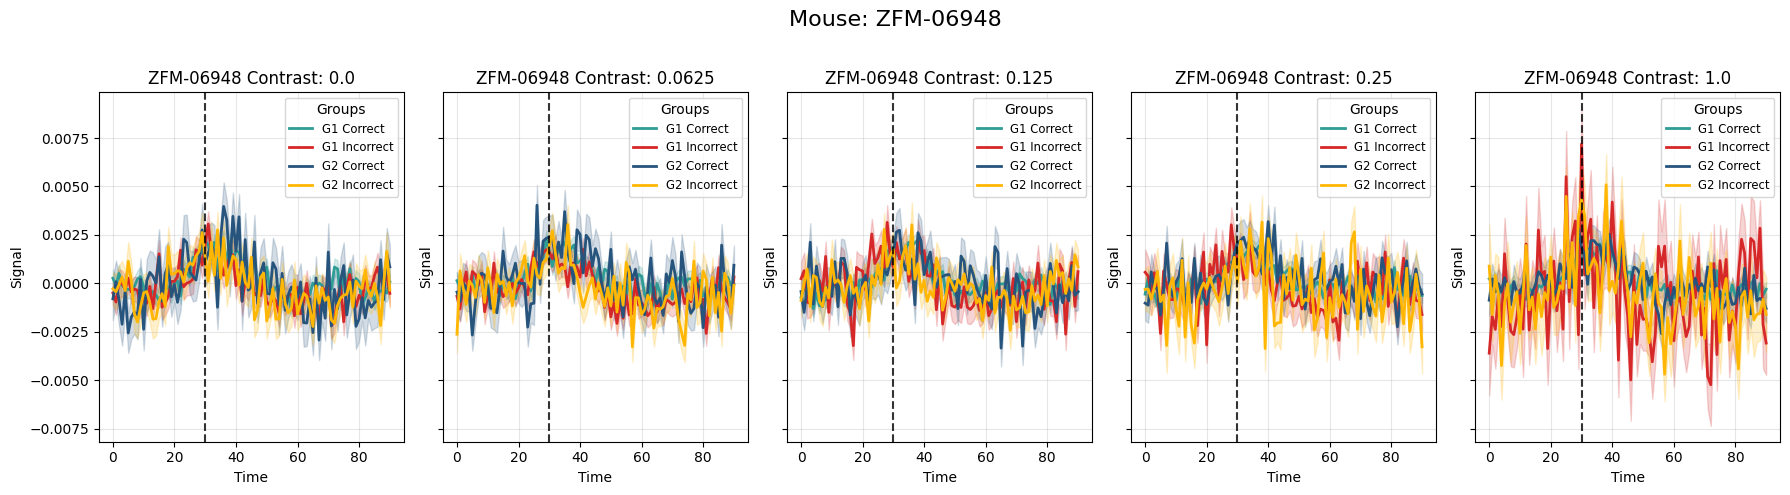

In [451]:
# Get all unique mice

# all_contrasts = [0.    , 0.0625, 0.125 , 0.25    , 1.    ] 


all_mice = df_trials_combined_DA['mouse'].unique()

# Iterate over each mouse and create plots
for mouse in all_mice:
    # Filter data for the current mouse
    mouse_indices = df_trials_combined_DA['mouse'] == mouse

    # Update group indices for this mouse
    group1_mouse_indices = group1_indices & mouse_indices
    group2_mouse_indices = group2_indices & mouse_indices

    # Set up the figure
    fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)  # 3 columns, 2 rows
    time = np.arange(psth_combined_DA.shape[0])  # Assuming time is the row index

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Iterate over contrasts and axes
    for ax, contrast in zip(axes, all_contrasts):
        for label, (group_indices, correctness) in {
            "G1 Correct": (group1_mouse_indices, 1),
            "G1 Incorrect": (group1_mouse_indices, -1),
            "G2 Correct": (group2_mouse_indices, 1),
            "G2 Incorrect": (group2_mouse_indices, -1)
        }.items():
            signal = extract_signals(group_indices, feedback_type, contrast, correctness)
            if signal.size > 0:  # Avoid plotting empty signals
                avg, sem = compute_avg_sem(signal)
                ax.plot(time, avg, color=colors[label], linewidth=2, label=label)
                ax.fill_between(time, avg - sem, avg + sem, color=colors[label], alpha=0.2)

        # Add a vertical line for the event time (baseline)
        ax.axvline(x=30, linestyle='dashed', color='black', alpha=0.8)
        ax.set_title(f"{mouse} Contrast: {contrast}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Signal')
        ax.grid(alpha=0.3)
        ax.legend(fontsize='small', title="Groups", loc='upper right')

    # Turn off any unused subplots
    for ax in axes[len(all_contrasts):]:
        ax.axis('off')

    # Adjust layout
    plt.suptitle(f"Mouse: {mouse}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the title
    plt.savefig(f'/mnt/h0/kb/data/performance_NM/biased_congruent_data_analysis/{NM}_{mouse}.png')
    plt.show()
